In [1]:
import subprocess
import sys

def install_and_import(package):
    """
    Checks if a package is installed. If not, installs it using pip 
    and then imports it.
    
    Note: 'pip install' name might differ from 'import' name 
    (e.g., 'scikit-learn' installs the 'sklearn' module).
    """
    try:
        # Attempt to import the package
        __import__(package)
        print(f"'{package}' is already installed.")
    except ImportError:
        print(f"'{package}' not found. Installing now...")
        try:
            # Run pip install command using subprocess
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            print(f"Successfully installed '{package}'.")
            # Try importing again after installation
            __import__(package)
        except subprocess.CalledProcessError as e:
            print(f"Failed to install '{package}'. Error: {e}")
        except ImportError:
            print(f"Successfully installed '{package}', but failed to import it afterward. You might need to restart your environment.")
    print("-" * 30)

In [2]:
install_and_import("datasets")
install_and_import("transformers")
install_and_import("torch")
install_and_import("scikit-learn")
install_and_import("SentencePiece")
install_and_import("accelerate>=0.26.0")
install_and_import("matplotlib")

'datasets' is already installed.
------------------------------
'transformers' is already installed.
------------------------------
'torch' is already installed.
------------------------------
'scikit-learn' not found. Installing now...
------------------------------
'SentencePiece' not found. Installing now...
------------------------------
'accelerate>=0.26.0' not found. Installing now...
------------------------------
'matplotlib' is already installed.
------------------------------


In [3]:
import pandas as pd
import numpy as np
import random
import torch
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix
)

In [4]:
# Check if CUDA (NVIDIA GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA not available. Using CPU.")

CUDA is available. Using GPU.


In [5]:

# --------------------------------------------------------
# 1. CONFIG
# --------------------------------------------------------

MODEL_NAME = "distilbert-base-uncased"
EPOCHS = 3
BATCH_SIZE = 16
LR = 5e-5

categories = [
    ("toxic_hard", "toxic", "not_toxic"),
    ("hateful_hard", "hateful", "not_hateful"),
    ("offensive_hard", "offensive", "not_offensive"),
]

# --------------------------------------------------------
# 2. LOAD DATA
# --------------------------------------------------------

df = pd.read_csv("dataset.csv")

# Convert all label columns to int (0/1)
for label_col, _, _ in categories:
    df[label_col] = df[label_col].astype(int)

# --------------------------------------------------------
# 3. TOKENIZER
# --------------------------------------------------------

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

# --------------------------------------------------------
# 4. TRAIN + EVALUATE
# --------------------------------------------------------

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    cm = confusion_matrix(labels, preds)
    return {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "confusion_matrix": cm.tolist()
    }

def zero_r_baseline(df, col):
    majority = df[col].mode().iloc[0]
    preds = np.full(len(df), majority)
    acc = accuracy_score(df[col], preds)
    return acc, majority

# --------------------------------------------------------
# TRAIN LOOP PER CATEGORY
# --------------------------------------------------------
'''
for label_col, label_true, label_false in categories:

    print("\n================================================")
    print(f" TRAINING CATEGORY: {label_col}")
    print("================================================\n")

    # ZeroR baseline
    zeror_acc, majority = zero_r_baseline(df, label_col)
    print(f"ZeroR (majority class) accuracy: {zeror_acc:.4f}  (majority={majority})\n")

    # Prepare HuggingFace dataset
    dataset = Dataset.from_pandas(df[["text", label_col]])

    # Convert labels to int and rename to "labels"
    dataset = dataset.map(lambda x: {"labels": int(x[label_col])})
    dataset = dataset.remove_columns([label_col])
    dataset = dataset.map(tokenize, batched=True)
    dataset.set_format("torch")

    # Train/validation split
    dataset_shuffled = dataset.shuffle(seed=42)
    train_size = int(0.8 * len(dataset_shuffled))
    ds_train = dataset_shuffled.select(range(train_size))
    ds_val   = dataset_shuffled.select(range(train_size, len(dataset_shuffled)))

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=2
    )

    # Training arguments
    training_args = TrainingArguments(
        output_dir=f"./results_{label_col}",
        eval_strategy="epoch",
        save_strategy="no",
        logging_steps=50,
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        load_best_model_at_end=False
    )

    # Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=ds_train,
        eval_dataset=ds_val,
        processing_class=tokenizer,
        compute_metrics=compute_metrics
    )

    # Train
    trainer.train()

    # Save model
    trainer.save_model(f"{label_col}_model")

    # ----------------------------------------------------
    # REAL-TIME CLASSIFIER FUNCTION FOR DEMO
    # ----------------------------------------------------

    # ----------------------------------------------------
    # CREATE PER-CATEGORY CLASSIFIER FUNCTIONS
    # ----------------------------------------------------
    
    if 'classifiers' not in globals():
        classifiers = {}  # Dictionary to hold all classifiers
    
    device = model.device
    
    def make_classifier(model, tokenizer, label_true, label_false, device):
        def classify(text):
            inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
            with torch.no_grad():
                outputs = model(**inputs)
            probs = torch.softmax(outputs.logits, dim=1)[0]
            pred = torch.argmax(probs).item()
            label = label_true if pred == 1 else label_false
            return {
                "label": label,
                "probabilities": {
                    label_false: float(probs[0]),
                    label_true: float(probs[1])
                }
            }
        return classify
    
    classifiers[label_col] = make_classifier(model, tokenizer, label_true, label_false, device)
'''

'\nfor label_col, label_true, label_false in categories:\n\n    print("\n================================================")\n    print(f" TRAINING CATEGORY: {label_col}")\n    print("================================================\n")\n\n    # ZeroR baseline\n    zeror_acc, majority = zero_r_baseline(df, label_col)\n    print(f"ZeroR (majority class) accuracy: {zeror_acc:.4f}  (majority={majority})\n")\n\n    # Prepare HuggingFace dataset\n    dataset = Dataset.from_pandas(df[["text", label_col]])\n\n    # Convert labels to int and rename to "labels"\n    dataset = dataset.map(lambda x: {"labels": int(x[label_col])})\n    dataset = dataset.remove_columns([label_col])\n    dataset = dataset.map(tokenize, batched=True)\n    dataset.set_format("torch")\n\n    # Train/validation split\n    dataset_shuffled = dataset.shuffle(seed=42)\n    train_size = int(0.8 * len(dataset_shuffled))\n    ds_train = dataset_shuffled.select(range(train_size))\n    ds_val   = dataset_shuffled.select(range(tr

In [6]:
def train_and_create_classifiers(df, categories, MODEL_NAME, EPOCHS, BATCH_SIZE, LR, seed=42):
    """
    Train a DistilBERT model for each category and return a dictionary of classifier functions.

    Args:
        df: pandas DataFrame containing "text" and category columns.
        categories: list of tuples (column_name, positive_label, negative_label)
        MODEL_NAME: HuggingFace model name
        EPOCHS: number of training epochs
        BATCH_SIZE: batch size
        LR: learning rate
        seed: random seed for reproducibility

    Returns:
        classifiers: dict mapping category column -> classifier function
    """

    import random
    import numpy as np
    import torch

    # -----------------------------
    # Set seeds for reproducibility
    # -----------------------------
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    classifiers = {}
    
    all_trainers = []
    
    for label_col, label_true, label_false in categories:

        # -----------------------------
        # ZeroR baseline (optional)
        # -----------------------------
        zeror_acc, majority = zero_r_baseline(df, label_col)
        print(f"\nZeroR for {label_col}: {zeror_acc:.4f}  (majority={majority})")

        # -----------------------------
        # Dataset preparation
        # -----------------------------
        dataset = Dataset.from_pandas(df[["text", label_col]])
        dataset = dataset.map(lambda x: {"labels": int(x[label_col])})
        dataset = dataset.remove_columns([label_col])
        dataset = dataset.map(tokenize, batched=True)
        dataset.set_format("torch")

        dataset_shuffled = dataset.shuffle(seed=seed)
        train_size = int(0.8 * len(dataset_shuffled))
        ds_train = dataset_shuffled.select(range(train_size))
        ds_val   = dataset_shuffled.select(range(train_size, len(dataset_shuffled)))

        # -----------------------------
        # Load model
        # -----------------------------
        model = AutoModelForSequenceClassification.from_pretrained(
            MODEL_NAME,
            num_labels=2
        )

        # -----------------------------
        # Training arguments
        # -----------------------------
        training_args = TrainingArguments(
            output_dir=f"./results_{label_col}_seed{seed}",
            eval_strategy="epoch",
            save_strategy="no",
            logging_steps=50,
            learning_rate=LR,
            per_device_train_batch_size=BATCH_SIZE,
            per_device_eval_batch_size=BATCH_SIZE,
            num_train_epochs=EPOCHS,
            weight_decay=0.01,
            load_best_model_at_end=False
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=ds_train,
            eval_dataset=ds_val,
            processing_class=tokenizer,
            compute_metrics=compute_metrics
        )

        # Train the model
        trainer.train()
        
        all_trainers.append(trainer)
        
        # Save the model (optional)
        trainer.save_model(f"{label_col}_model_seed{seed}")

        # -----------------------------
        # Create classifier function
        # -----------------------------
        device = model.device

        def make_classifier(model, tokenizer, label_true, label_false, device):
            def classify(text):
                inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128).to(device)
                with torch.no_grad():
                    outputs = model(**inputs)
                probs = torch.softmax(outputs.logits, dim=1)[0]
                pred = torch.argmax(probs).item()
                label = label_true if pred == 1 else label_false
                return {
                    "label": label,
                    "probabilities": {
                        label_false: float(probs[0]),
                        label_true: float(probs[1])
                    }
                }
            return classify

        classifiers[label_col] = make_classifier(model, tokenizer, label_true, label_false, device)

    return classifiers, trainer


In [7]:
seeds = [42, 123]
all_classifiers = []
all_trainers = []

for seed in seeds:
    cls, trs = train_and_create_classifiers(df, categories, MODEL_NAME, EPOCHS, BATCH_SIZE, LR, seed)
    all_classifiers.append(cls)
    all_trainers.append(trs)



ZeroR for toxic_hard: 0.8291  (majority=0)


Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.336300,0.340498,0.857963,0.612500,0.418803,0.497462,"[[549, 31], [68, 49]]"
2,0.241200,0.405825,0.875179,0.714286,0.427350,0.534759,"[[560, 20], [67, 50]]"
3,0.135900,0.535231,0.856528,0.584158,0.504274,0.541284,"[[538, 42], [58, 59]]"



ZeroR for hateful_hard: 0.8225  (majority=0)


Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.391900,0.350444,0.847920,0.643836,0.370079,0.470000,"[[544, 26], [80, 47]]"
2,0.238300,0.387215,0.857963,0.705882,0.377953,0.492308,"[[550, 20], [79, 48]]"
3,0.129900,0.447615,0.862267,0.639640,0.559055,0.596639,"[[530, 40], [56, 71]]"



ZeroR for offensive_hard: 0.7038  (majority=0)


Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.412500,0.413099,0.826399,0.781690,0.552239,0.647230,"[[465, 31], [90, 111]]"
2,0.285700,0.496722,0.813486,0.729032,0.562189,0.634831,"[[454, 42], [88, 113]]"
3,0.157200,0.678651,0.823529,0.698980,0.681592,0.690176,"[[437, 59], [64, 137]]"



ZeroR for toxic_hard: 0.8291  (majority=0)


Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.341300,0.353464,0.840746,0.527950,0.708333,0.604982,"[[501, 76], [35, 85]]"
2,0.269400,0.343682,0.882353,0.796875,0.425000,0.554348,"[[564, 13], [69, 51]]"
3,0.098600,0.452775,0.868006,0.637255,0.541667,0.585586,"[[540, 37], [55, 65]]"



ZeroR for hateful_hard: 0.8225  (majority=0)


Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.348000,0.391239,0.837877,0.782609,0.142857,0.241611,"[[566, 5], [108, 18]]"
2,0.277400,0.417152,0.855093,0.666667,0.396825,0.497512,"[[546, 25], [76, 50]]"
3,0.129400,0.542523,0.845050,0.590000,0.468254,0.522124,"[[530, 41], [67, 59]]"



ZeroR for offensive_hard: 0.7038  (majority=0)


Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Map:   0%|          | 0/3481 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,0.464300,0.410294,0.826399,0.729412,0.623116,0.672087,"[[452, 46], [75, 124]]"
2,0.284600,0.456969,0.819225,0.691099,0.663317,0.676923,"[[439, 59], [67, 132]]"
3,0.116200,0.693244,0.816356,0.685864,0.658291,0.671795,"[[438, 60], [68, 131]]"


In [14]:
# ----------------------------------------------------
# WRAPPER FUNCTION TO CALL ALL CLASSIFIERS
# ----------------------------------------------------

def classify_all(text):
    results = {}
    for label_col, _, _ in categories:
        results[label_col] = classifiers[label_col](text)
    return results

# ----------------------------------------------------
# DEMO
# ----------------------------------------------------

tweet1 = "I hate you and your stupid face."
tweet2 = "Hope you’re having a great day!"

print("\nIndividual classifiers:")
for classifiers in all_classifiers:
    for label_col, _, _ in categories:
        print(f"{label_col}:", classifiers[label_col](tweet1))
    
    print("\nAll classifiers at once:")
    print(classify_all(tweet1))
    print(classify_all(tweet2))


Individual classifiers:
toxic_hard: {'label': 'toxic', 'probabilities': {'not_toxic': 0.007140111643821001, 'toxic': 0.9928598999977112}}
hateful_hard: {'label': 'hateful', 'probabilities': {'not_hateful': 0.3956103026866913, 'hateful': 0.6043896675109863}}
offensive_hard: {'label': 'offensive', 'probabilities': {'not_offensive': 0.004542522598057985, 'offensive': 0.9954575300216675}}

All classifiers at once:
{'toxic_hard': {'label': 'toxic', 'probabilities': {'not_toxic': 0.007140111643821001, 'toxic': 0.9928598999977112}}, 'hateful_hard': {'label': 'hateful', 'probabilities': {'not_hateful': 0.3956103026866913, 'hateful': 0.6043896675109863}}, 'offensive_hard': {'label': 'offensive', 'probabilities': {'not_offensive': 0.004542522598057985, 'offensive': 0.9954575300216675}}}
{'toxic_hard': {'label': 'not_toxic', 'probabilities': {'not_toxic': 0.9934452772140503, 'toxic': 0.006554765626788139}}, 'hateful_hard': {'label': 'not_hateful', 'probabilities': {'not_hateful': 0.9943037033081

In [15]:
def print_classification(tweet, results):
    """
    Pretty-print classification results for a single tweet,
    showing each positive category with the probability it is True.
    
    Args:
        tweet (str): The text being classified.
        results (dict): Output of classify_all(tweet).
    """
    print(f"Tweet: {tweet}\n")
    for category, outcome in results.items():
        # Get the positive label (True label) from your original categories mapping
        positive_label = category.split('_')[0]  # e.g., "toxic_hard" -> "toxic"
        prob_positive = outcome['probabilities'][positive_label]
        print(f"{positive_label}: {prob_positive*100:.2f}%")
    print("-"*40)


In [16]:
tweets = [
    # 1. not toxic, not hateful, not offensive
    "I think we should all try to listen to each other's political opinions respectfully.",
    
    # 2. not toxic, not hateful, offensive
    "That new policy is absolutely absurd and makes no sense at all!",
    
    # 3. not toxic, hateful, not offensive
    "I can't stand that political party; their supporters are clueless and dangerous.",
    
    # 4. not toxic, hateful, offensive
    "Those politicians and everyone who votes for them are disgusting and pathetic.",
    
    # 5. toxic, not hateful, not offensive
    "You are completely wrong and your arguments are nonsense.",
    
    # 6. toxic, not hateful, offensive
    "You idiot, how can anyone take that politician seriously?!",
    
    # 7. toxic, hateful, not offensive
    "I hate that entire party and everything they stand for.",
    
    # 8. toxic, hateful, offensive
    "I hate you and everyone supporting that corrupt regime, you disgusting fools!"
]

expected_values = [
    {"toxic": 0, "hateful": 0, "offensive": 0},
    {"toxic": 0, "hateful": 0, "offensive": 1},
    {"toxic": 0, "hateful": 1, "offensive": 0},
    {"toxic": 0, "hateful": 1, "offensive": 1},
    {"toxic": 1, "hateful": 0, "offensive": 0},
    {"toxic": 1, "hateful": 0, "offensive": 1},
    {"toxic": 1, "hateful": 1, "offensive": 0},
    {"toxic": 1, "hateful": 1, "offensive": 1},
]

# Example usage with classify_all and print_classification
for tweet, expected in zip(tweets, expected_values):
    results = classify_all(tweet)
    print("[expected values]")
    for cat, val in expected.items():
        status = "yes" if val else "no"
        print(f"{cat}: {status}")
    print("\n[classifier output]")
    print_classification(tweet, results)
    print("="*50)


[expected values]
toxic: no
hateful: no
offensive: no

[classifier output]
Tweet: I think we should all try to listen to each other's political opinions respectfully.

toxic: 0.62%
hateful: 0.58%
offensive: 0.51%
----------------------------------------
[expected values]
toxic: no
hateful: no
offensive: yes

[classifier output]
Tweet: That new policy is absolutely absurd and makes no sense at all!

toxic: 0.54%
hateful: 0.55%
offensive: 0.48%
----------------------------------------
[expected values]
toxic: no
hateful: yes
offensive: no

[classifier output]
Tweet: I can't stand that political party; their supporters are clueless and dangerous.

toxic: 0.66%
hateful: 30.94%
offensive: 30.94%
----------------------------------------
[expected values]
toxic: no
hateful: yes
offensive: yes

[classifier output]
Tweet: Those politicians and everyone who votes for them are disgusting and pathetic.

toxic: 12.86%
hateful: 98.27%
offensive: 8.12%
----------------------------------------
[expect

In [17]:
for tweet, expected in zip(tweets, expected_values):
    print("\n" + "="*60)
    print(f"Tweet: {tweet}")
    print("Expected labels:", expected)
    
    # Iterate over seeds / runs
    for seed_idx, classifiers in enumerate(all_classifiers):
        print(f"\n--- Seed {seed_idx+1} ---")
        for label_col, positive_label, _ in categories:
            result = classifiers[label_col](tweet)
            # Print only the positive label with probability
            prob = result['probabilities'][positive_label] * 100
            print(f"{positive_label}: {prob:.2f}%")



Tweet: I think we should all try to listen to each other's political opinions respectfully.
Expected labels: {'toxic': 0, 'hateful': 0, 'offensive': 0}

--- Seed 1 ---
toxic: 0.42%
hateful: 0.60%
offensive: 0.53%

--- Seed 2 ---
toxic: 0.62%
hateful: 0.58%
offensive: 0.51%

Tweet: That new policy is absolutely absurd and makes no sense at all!
Expected labels: {'toxic': 0, 'hateful': 0, 'offensive': 1}

--- Seed 1 ---
toxic: 0.37%
hateful: 0.56%
offensive: 0.41%

--- Seed 2 ---
toxic: 0.54%
hateful: 0.55%
offensive: 0.48%

Tweet: I can't stand that political party; their supporters are clueless and dangerous.
Expected labels: {'toxic': 0, 'hateful': 1, 'offensive': 0}

--- Seed 1 ---
toxic: 0.62%
hateful: 89.62%
offensive: 15.34%

--- Seed 2 ---
toxic: 0.66%
hateful: 30.94%
offensive: 30.94%

Tweet: Those politicians and everyone who votes for them are disgusting and pathetic.
Expected labels: {'toxic': 0, 'hateful': 1, 'offensive': 1}

--- Seed 1 ---
toxic: 3.92%
hateful: 97.85%
offe

In [18]:
def confidence_descriptor_for_expected(prob_positive, expected_label, positive_label):
    # expected_label is “toxic” or “not_toxic”
    # positive_label is “toxic”
    is_expected_positive = (expected_label == positive_label)

    # If expected positive → high prob shows confidence
    # If expected negative → low prob shows confidence
    prob_toward_expected = prob_positive if is_expected_positive else (100 - prob_positive)

    # Confidence grading
    if prob_toward_expected >= 90:
        return "extremely confident"
    elif prob_toward_expected >= 75:
        return "highly confident"
    elif prob_toward_expected >= 55:
        return "somewhat confident"
    elif prob_toward_expected >= 45:
        return "uncertain"
    elif prob_toward_expected >= 25:
        return "weakly confident"
    else:
        return "barely confident"


def compare_expected_vs_actual(tweets, expected_values, all_classifiers, categories):
    """
    tweets = [...]
    expected_values = [ {"toxic":0, "hateful":1, "offensive":1}, ... ]
    all_classifiers = [ dict_of_classifiers_for_seed1, dict_for_seed2, dict_for_seed3 ]
    categories = [ ("toxic_hard","toxic","not_toxic"), ... ]
    """

    # 🔧 NEW: mapping dataset column → expected key
    label_key_map = {
        "toxic_hard": "toxic",
        "hateful_hard": "hateful",
        "offensive_hard": "offensive"
    }

    for tweet, expected_dict in zip(tweets, expected_values):

        print("\n" + "="*70)
        print(f"Tweet: {tweet}")
        print(f"Expected: {expected_dict}")

        # Loop across seeds
        for seed_idx, classifiers in enumerate(all_classifiers):
            print(f"\n--- Seed {seed_idx+1} Results ---")

            # Loop across categories (toxic/hateful/offensive)
            for label_col, positive_label, negative_label in categories:

                # Translate category name to expected_values key
                expected_key = label_key_map[label_col]

                # Convert 0/1 to true label
                expected_label = (
                    positive_label if expected_dict[expected_key] == 1 
                    else negative_label
                )

                # Run classifier
                result = classifiers[label_col](tweet)

                predicted_label = result["label"]
                prob_positive = result["probabilities"][positive_label] * 100

                # accurate or not?
                accuracy = "ACCURATE" if predicted_label == expected_label else "INACCURATE"

                # describe confidence relative to expected
                conf_desc = confidence_descriptor_for_expected(
                    prob_positive, expected_label, positive_label
                )

                print(
                    f"{positive_label}:  \t{prob_positive:.2f}% "
                    f"({conf_desc}, {accuracy}, predicted={predicted_label})"
                )

In [19]:
compare_expected_vs_actual(tweets, expected_values, all_classifiers, categories)


Tweet: I think we should all try to listen to each other's political opinions respectfully.
Expected: {'toxic': 0, 'hateful': 0, 'offensive': 0}

--- Seed 1 Results ---
toxic:  	0.42% (extremely confident, ACCURATE, predicted=not_toxic)
hateful:  	0.60% (extremely confident, ACCURATE, predicted=not_hateful)
offensive:  	0.53% (extremely confident, ACCURATE, predicted=not_offensive)

--- Seed 2 Results ---
toxic:  	0.62% (extremely confident, ACCURATE, predicted=not_toxic)
hateful:  	0.58% (extremely confident, ACCURATE, predicted=not_hateful)
offensive:  	0.51% (extremely confident, ACCURATE, predicted=not_offensive)

Tweet: That new policy is absolutely absurd and makes no sense at all!
Expected: {'toxic': 0, 'hateful': 0, 'offensive': 1}

--- Seed 1 Results ---
toxic:  	0.37% (extremely confident, ACCURATE, predicted=not_toxic)
hateful:  	0.56% (extremely confident, ACCURATE, predicted=not_hateful)
offensive:  	0.41% (barely confident, INACCURATE, predicted=not_offensive)

--- Seed 

Built predictions DataFrame with 48 rows.
Saved raw predictions to: /mnt/data/llm_toxicity_viz\predictions_long_table.csv


,seed,seed_idx,tweet_index,tweet,category_col,category,prob_positive,pred_label,expected_binary,correct
0,Seed 1,1,0,I think we should all try to listen to each ot...,toxic_hard,toxic,0.423621,not_toxic,0,True
1,Seed 1,1,0,I think we should all try to listen to each ot...,hateful_hard,hateful,0.595403,not_hateful,0,True
2,Seed 1,1,0,I think we should all try to listen to each ot...,offensive_hard,offensive,0.525740,not_offensive,0,True
3,Seed 1,1,1,That new policy is absolutely absurd and makes...,toxic_hard,toxic,0.366702,not_toxic,0,True
4,Seed 1,1,1,That new policy is absolutely absurd and makes...,hateful_hard,hateful,0.564140,not_hateful,0,True
5,Seed 1,1,1,That new policy is absolutely absurd and makes...,offensive_hard,offensive,0.406347,not_offensive,1,False
6,Seed 1,1,2,I can't stand that political party; their supp...,toxic_hard,toxic,0.616224,not_toxic,0,True
7,Seed 1,1,2,I can't stand that political party; their supp...,hateful_hard,hateful,89.624828,hateful,1,True
8,Seed 1,1,2,I can't stand that political party; their supp...,offensive_hard,offensive,15.344992,not_offensive,0,True
9,Seed 1,1,3,Those politicians and everyone who votes for t...,toxic_hard,toxic,3.924201,not_toxic,0,True


Saved: /mnt/data/llm_toxicity_viz\avg_prob_by_category_seed.png


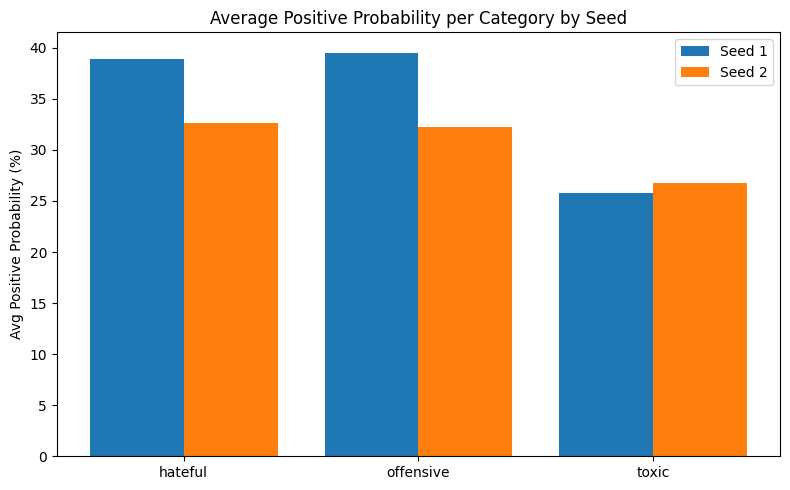

Saved: /mnt/data/llm_toxicity_viz\heatmap_toxic.png


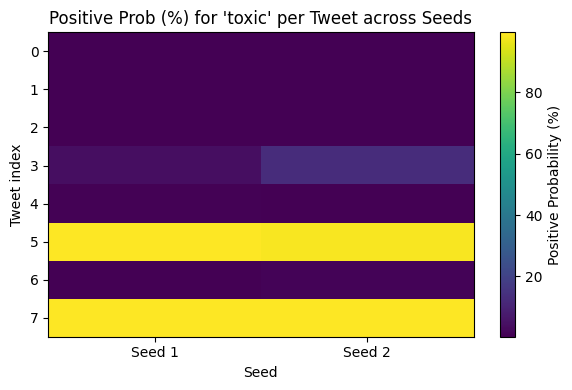

Saved: /mnt/data/llm_toxicity_viz\heatmap_hateful.png


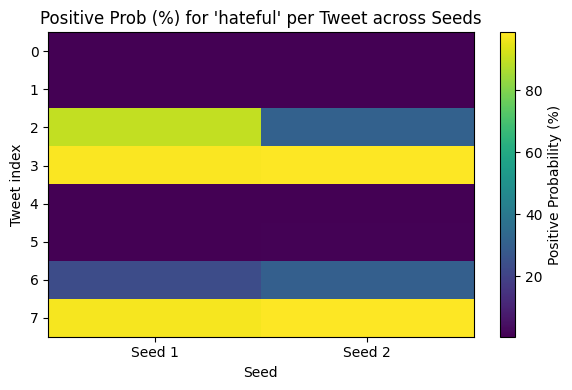

Saved: /mnt/data/llm_toxicity_viz\heatmap_offensive.png


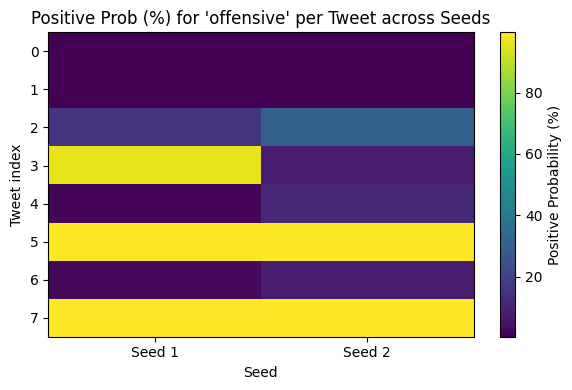

Saved: /mnt/data/llm_toxicity_viz\accuracy_by_category_seed.png


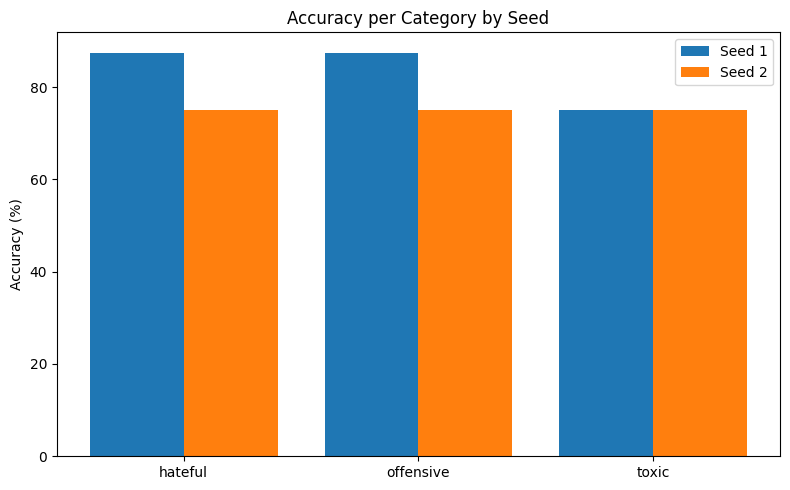

Saved: /mnt/data/llm_toxicity_viz\hist_toxic.png


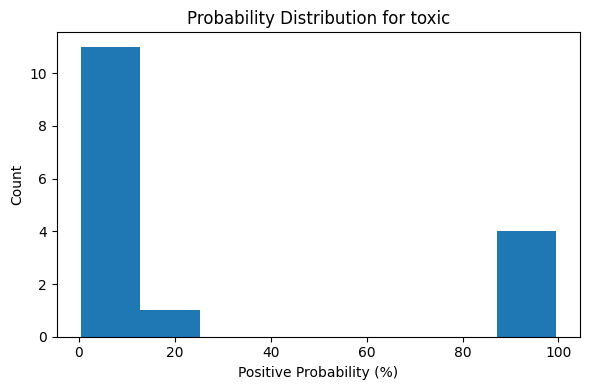

Saved: /mnt/data/llm_toxicity_viz\hist_hateful.png


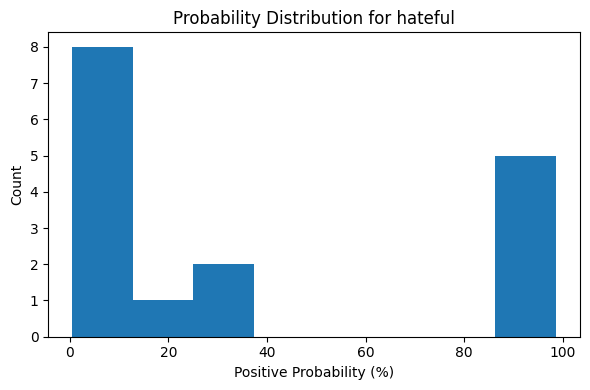

Saved: /mnt/data/llm_toxicity_viz\hist_offensive.png


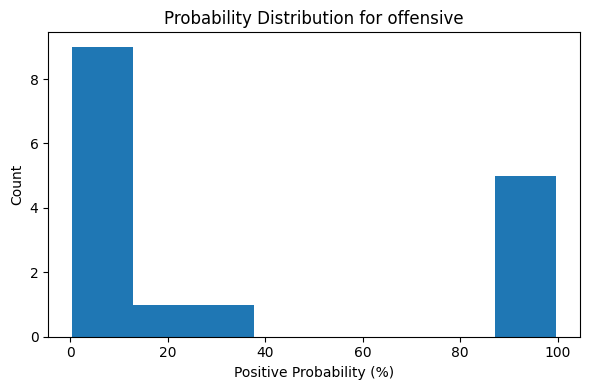

Saved: /mnt/data/llm_toxicity_viz\stddev_toxic.png


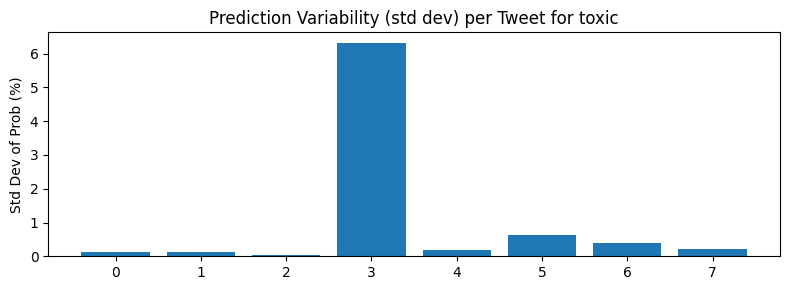

Saved: /mnt/data/llm_toxicity_viz\stddev_hateful.png


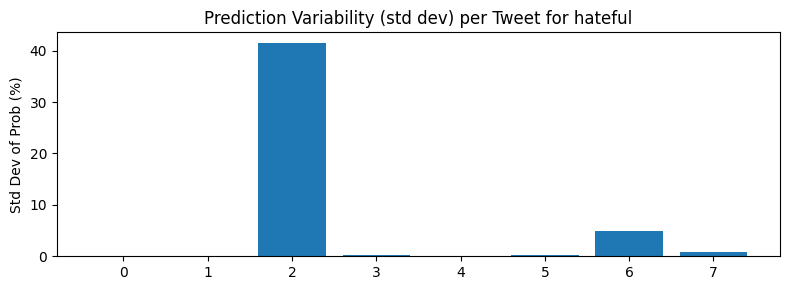

Saved: /mnt/data/llm_toxicity_viz\stddev_offensive.png


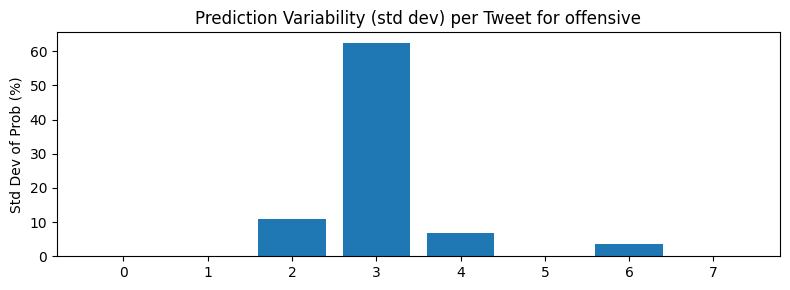

Saved summary CSV: /mnt/data/llm_toxicity_viz\summary_table.csv


,tweet_index,tweet,toxic_mean_prob,toxic_accuracy_pct,hateful_mean_prob,hateful_accuracy_pct,offensive_mean_prob,offensive_accuracy_pct
0,0,I think we should all try to listen to each ot...,0.520921,100.0,0.585297,100.0,0.518962,100.0
1,1,That new policy is absolutely absurd and makes...,0.453080,100.0,0.556599,100.0,0.440948,0.0
2,2,I can't stand that political party; their supp...,0.637228,100.0,60.280086,50.0,23.141767,100.0
3,3,Those politicians and everyone who votes for t...,8.389953,100.0,98.060963,100.0,52.258177,50.0
4,4,You are completely wrong and your arguments ar...,0.854695,0.0,0.720048,100.0,6.565739,100.0



Produced files:
avg_prob_by_category_seed : /mnt/data/llm_toxicity_viz\avg_prob_by_category_seed.png
accuracy_by_category_seed : /mnt/data/llm_toxicity_viz\accuracy_by_category_seed.png
heatmaps : ['/mnt/data/llm_toxicity_viz\\heatmap_toxic.png', '/mnt/data/llm_toxicity_viz\\heatmap_hateful.png', '/mnt/data/llm_toxicity_viz\\heatmap_offensive.png']
histograms : ['/mnt/data/llm_toxicity_viz\\hist_toxic.png', '/mnt/data/llm_toxicity_viz\\hist_hateful.png', '/mnt/data/llm_toxicity_viz\\hist_offensive.png']
stddevs : ['/mnt/data/llm_toxicity_viz\\stddev_toxic.png', '/mnt/data/llm_toxicity_viz\\stddev_hateful.png', '/mnt/data/llm_toxicity_viz\\stddev_offensive.png']
summary_csv : /mnt/data/llm_toxicity_viz\summary_table.csv
raw_predictions_csv : /mnt/data/llm_toxicity_viz\predictions_long_table.csv


In [20]:
# ------- Paste this cell into your notebook (run after training completes) -------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Output directory (created if missing)
out_dir = "/mnt/data/llm_toxicity_viz"
os.makedirs(out_dir, exist_ok=True)

# Map column names used in categories to keys used in expected_values
label_key_map = {
    "toxic_hard": "toxic",
    "hateful_hard": "hateful",
    "offensive_hard": "offensive"
}

# Build records list from your in-memory variables:
records = []
for seed_idx, classifiers in enumerate(all_classifiers, start=1):
    for i, tweet in enumerate(tweets):
        expected = expected_values[i]
        for label_col, positive_label, negative_label in categories:
            expected_key = label_key_map[label_col]
            result = classifiers[label_col](tweet)
            prob_positive = result["probabilities"][positive_label]  # 0..1
            pred_label = result["label"]
            expected_binary = expected[expected_key]
            correct = (pred_label == (positive_label if expected_binary == 1 else negative_label))
            records.append({
                "seed": f"Seed {seed_idx}",
                "seed_idx": seed_idx,
                "tweet_index": i,
                "tweet": tweet,
                "category_col": label_col,
                "category": positive_label,
                "prob_positive": prob_positive * 100,   # convert to percent
                "pred_label": pred_label,
                "expected_binary": expected_binary,
                "correct": correct
            })

df_preds = pd.DataFrame.from_records(records)
print("Built predictions DataFrame with", len(df_preds), "rows.")

# Save raw predictions table
csv_preds = os.path.join(out_dir, "predictions_long_table.csv")
df_preds.to_csv(csv_preds, index=False)
print("Saved raw predictions to:", csv_preds)

# Show a small sample
display(df_preds.head(10))

# -----------------------
# 1) Grouped bar chart: average probability per category across seeds
# -----------------------
avg_df = df_preds.groupby(["category", "seed"])["prob_positive"].mean().unstack()
fig, ax = plt.subplots(figsize=(8,5))
cats = avg_df.index.tolist()
x = np.arange(len(cats))
n_seeds = len(avg_df.columns)
width = 0.8 / max(1, n_seeds)

for i, seed in enumerate(avg_df.columns):
    ax.bar(x + i*width, avg_df[seed].values, width, label=seed)
ax.set_xticks(x + width*(n_seeds-1)/2)
ax.set_xticklabels(cats)
ax.set_ylabel("Avg Positive Probability (%)")
ax.set_title("Average Positive Probability per Category by Seed")
ax.legend()
fig.tight_layout()
fpath = os.path.join(out_dir, "avg_prob_by_category_seed.png")
fig.savefig(fpath)
print("Saved:", fpath)
plt.show()

# -----------------------
# 2) Heatmap: probability per tweet across seeds for each category
# -----------------------
heatmap_files = []
for category in df_preds["category"].unique():
    pivot = df_preds[df_preds["category"]==category].pivot(index="tweet_index", columns="seed", values="prob_positive")
    pivot = pivot.sort_index()
    fig, ax = plt.subplots(figsize=(6, max(4, 0.5*len(pivot))))
    im = ax.imshow(pivot.values, aspect='auto')
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([f"{i}" for i in pivot.index])
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels(pivot.columns)
    ax.set_xlabel("Seed")
    ax.set_ylabel("Tweet index")
    ax.set_title(f"Positive Prob (%) for '{category}' per Tweet across Seeds")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Positive Probability (%)")
    fig.tight_layout()
    path = os.path.join(out_dir, f"heatmap_{category}.png")
    fig.savefig(path)
    heatmap_files.append(path)
    print("Saved:", path)
    plt.show()

# -----------------------
# 3) Accuracy bar chart per seed and category
# -----------------------
acc_df = df_preds.groupby(["category","seed"])["correct"].mean().unstack() * 100
fig, ax = plt.subplots(figsize=(8,5))
x = np.arange(len(acc_df.index))
n_seeds = len(acc_df.columns)
width = 0.8 / max(1, n_seeds)
for i, seed in enumerate(acc_df.columns):
    ax.bar(x + i*width, acc_df[seed].values, width, label=seed)
ax.set_xticks(x + width*(n_seeds-1)/2)
ax.set_xticklabels(acc_df.index.tolist())
ax.set_ylabel("Accuracy (%)")
ax.set_title("Accuracy per Category by Seed")
ax.legend()
fig.tight_layout()
fpath = os.path.join(out_dir, "accuracy_by_category_seed.png")
fig.savefig(fpath)
print("Saved:", fpath)
plt.show()

# -----------------------
# 4) Histograms: probability distribution per category
# -----------------------
hist_files = []
for category in df_preds["category"].unique():
    vals = df_preds[df_preds["category"]==category]["prob_positive"]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.hist(vals, bins=8)
    ax.set_title(f"Probability Distribution for {category}")
    ax.set_xlabel("Positive Probability (%)")
    ax.set_ylabel("Count")
    fig.tight_layout()
    p = os.path.join(out_dir, f"hist_{category}.png")
    fig.savefig(p)
    hist_files.append(p)
    print("Saved:", p)
    plt.show()

# -----------------------
# 5) Variability (std dev) per tweet for each category
# -----------------------
stddev_files = []
for category in df_preds["category"].unique():
    sub = df_preds[df_preds["category"]==category].pivot(index="tweet_index", columns="seed", values="prob_positive")
    stds = sub.std(axis=1)
    fig, ax = plt.subplots(figsize=(8,3))
    ax.bar(range(len(stds)), stds.values)
    ax.set_xticks(range(len(stds)))
    ax.set_xticklabels(stds.index)
    ax.set_ylabel("Std Dev of Prob (%)")
    ax.set_title(f"Prediction Variability (std dev) per Tweet for {category}")
    fig.tight_layout()
    p = os.path.join(out_dir, f"stddev_{category}.png")
    fig.savefig(p)
    stddev_files.append(p)
    print("Saved:", p)
    plt.show()

# -----------------------
# 6) Per-tweet CSV summary: mean prob & accuracy across seeds per category
# -----------------------
summary_records = []
for i, tweet in enumerate(tweets):
    row = {"tweet_index": i, "tweet": tweet}
    for category in df_preds["category"].unique():
        sub = df_preds[(df_preds["tweet_index"]==i) & (df_preds["category"]==category)]
        row[f"{category}_mean_prob"] = sub["prob_positive"].mean()
        row[f"{category}_accuracy_pct"] = sub["correct"].mean()*100
    summary_records.append(row)
summary_df = pd.DataFrame(summary_records)
summary_csv = os.path.join(out_dir, "summary_table.csv")
summary_df.to_csv(summary_csv, index=False)
print("Saved summary CSV:", summary_csv)
display(summary_df.head())

# Final list of produced files
produced = {
    "avg_prob_by_category_seed": os.path.join(out_dir, "avg_prob_by_category_seed.png"),
    "accuracy_by_category_seed": os.path.join(out_dir, "accuracy_by_category_seed.png"),
    "heatmaps": [os.path.join(out_dir, os.path.basename(p)) for p in heatmap_files],
    "histograms": [os.path.join(out_dir, os.path.basename(p)) for p in hist_files],
    "stddevs": [os.path.join(out_dir, os.path.basename(p)) for p in stddev_files],
    "summary_csv": summary_csv,
    "raw_predictions_csv": csv_preds
}
print("\nProduced files:")
for k,v in produced.items():
    print(k, ":", v)
# -----------------------------------------------------------------------


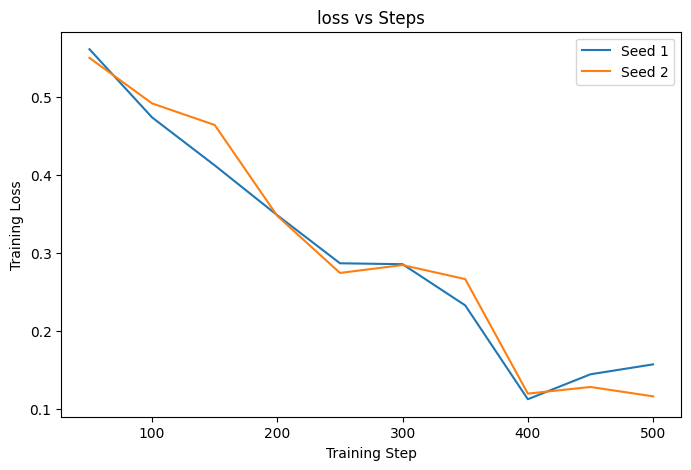

Saved: /mnt/data/training_viz\loss_curve.png


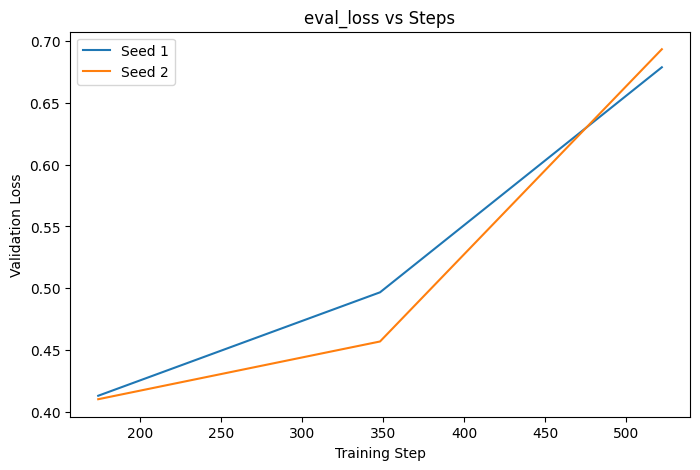

Saved: /mnt/data/training_viz\eval_loss_curve.png


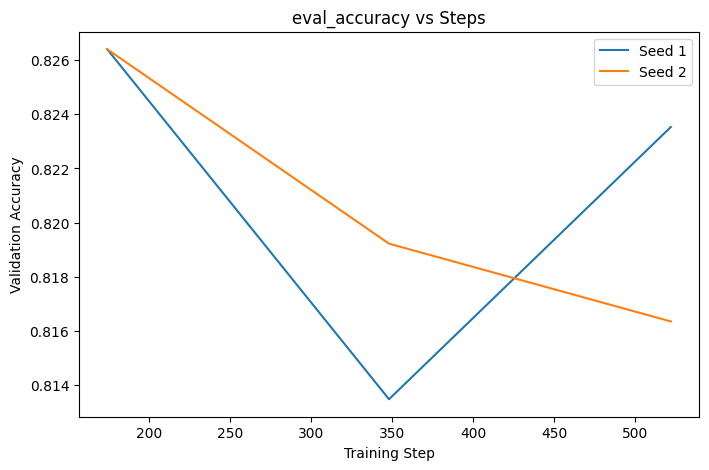

Saved: /mnt/data/training_viz\eval_accuracy_curve.png


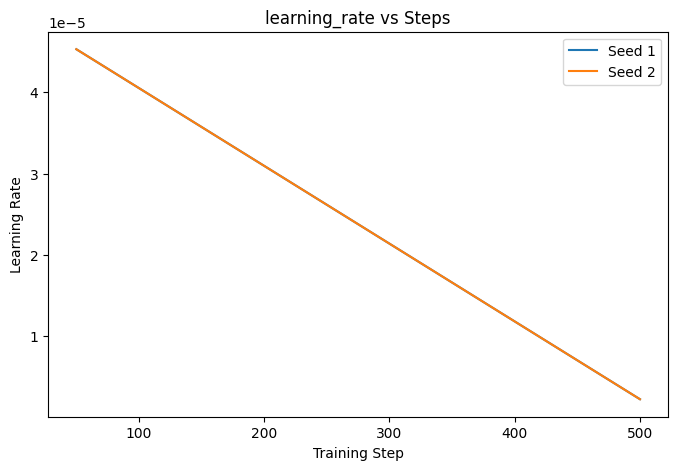

Saved: /mnt/data/training_viz\learning_rate_curve.png


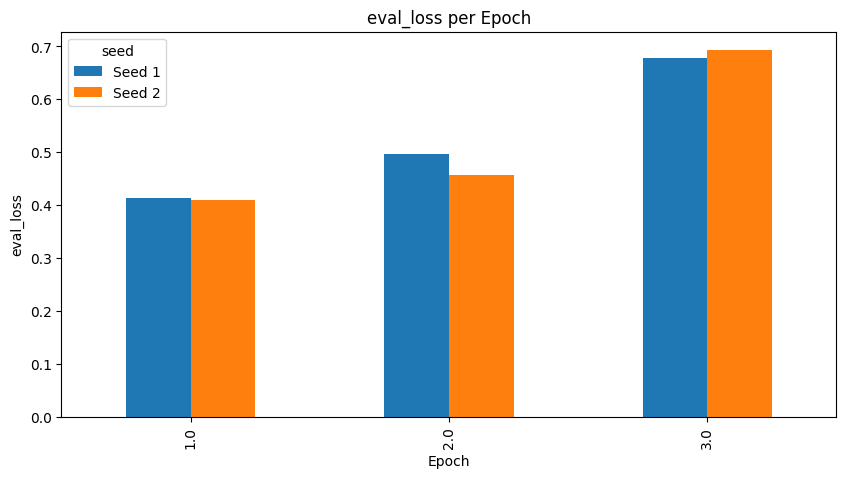

Saved: /mnt/data/training_viz\eval_loss_per_epoch.png


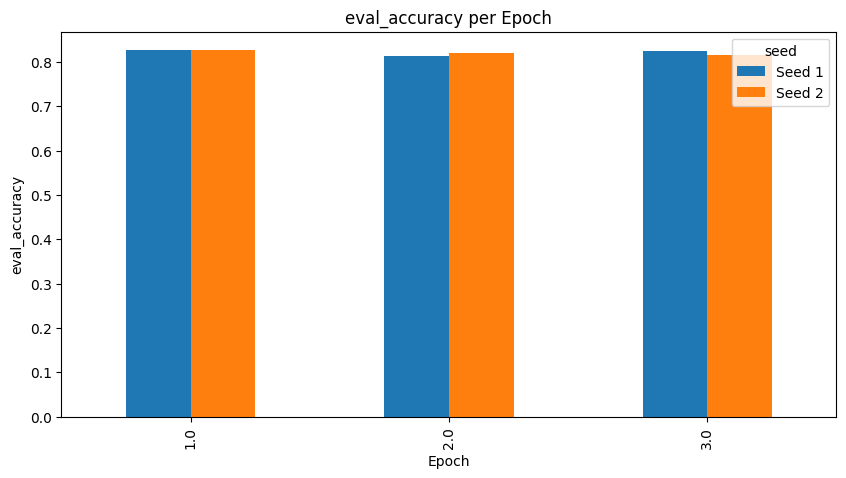

Saved: /mnt/data/training_viz\eval_accuracy_per_epoch.png


In [23]:
# --------------------------------------------------------
# PLOTTING TRAINING AND EVALUATION METRICS
# --------------------------------------------------------

import os
import matplotlib.pyplot as plt
import pandas as pd

# Folder for images
out_dir = "/mnt/data/training_viz"
os.makedirs(out_dir, exist_ok=True)

# -----------------------------
# Helper function: plot metric
# -----------------------------
def plot_metric(df_logs, metric_name, ylabel=None, out_dir=out_dir):
    """
    Plot a metric from HuggingFace Trainer logs, ignoring NaNs.

    Args:
        df_logs (pd.DataFrame): Combined logs from all trainers.
        metric_name (str): Column name to plot, e.g., 'loss', 'eval_loss'.
        ylabel (str, optional): Label for y-axis.
        out_dir (str): Folder to save plots.
    """
    plt.figure(figsize=(8,5))
    
    # Plot per seed
    for seed in df_logs["seed"].unique():
        subset = df_logs[df_logs["seed"] == seed]
        subset = subset[subset[metric_name].notnull()]
        if not subset.empty:
            plt.plot(subset["step"], subset[metric_name], label=seed)
    
    plt.xlabel("Training Step")
    plt.ylabel(ylabel or metric_name)
    plt.title(f"{metric_name} vs Steps")
    plt.legend()
    
    fname = os.path.join(out_dir, f"{metric_name}_curve.png")
    plt.savefig(fname)
    plt.show()
    print("Saved:", fname)

# -----------------------------
# Helper function: plot per-epoch bars
# -----------------------------
def plot_epoch_bars(df_logs, metric_name, out_dir=out_dir):
    """
    Plot a bar chart per epoch for a given evaluation metric, ignoring NaNs.
    """
    df_eval = df_logs[df_logs[metric_name].notnull()]
    if not df_eval.empty:
        pivot = df_eval.pivot_table(index="epoch", columns="seed", values=metric_name)
        pivot.plot.bar(figsize=(10,5))
        plt.title(f"{metric_name} per Epoch")
        plt.ylabel(metric_name)
        plt.xlabel("Epoch")
        
        fname = os.path.join(out_dir, f"{metric_name}_per_epoch.png")
        plt.savefig(fname)
        plt.show()
        print("Saved:", fname)

# -----------------------------
# Plot training & evaluation curves
# -----------------------------
metrics_to_plot = {
    "loss": "Training Loss",
    "eval_loss": "Validation Loss",
    "eval_accuracy": "Validation Accuracy",
    "learning_rate": "Learning Rate"
}

for metric, ylabel in metrics_to_plot.items():
    if metric in df_logs.columns:
        plot_metric(df_logs, metric, ylabel)

# -----------------------------
# Plot per-epoch evaluation bars
# -----------------------------
epoch_metrics = ["eval_loss", "eval_accuracy"]
for metric in epoch_metrics:
    if metric in df_logs.columns and "epoch" in df_logs.columns:
        plot_epoch_bars(df_logs, metric)
